In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset') # insert ypu kaggle username and key


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadsafir
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/noobyogi0100/shoe-dataset


100%|██████████| 324M/324M [00:03<00:00, 104MB/s]


In [ ]:

# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for facial expression recognition.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("shoe-dataset/shoeTypeClassifierDataset/training/", transform=train_transform)
test_dataset = datasets.ImageFolder("shoe-dataset/shoeTypeClassifierDataset/validation/", transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 1493 samples
Train set has 1343 samples
Validation set has 150 samples
Test set has 300 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

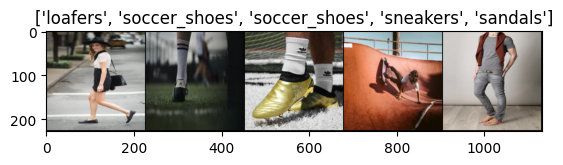

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['boots','flip_flops','loafers','sandals','sneakers','soccer_shoes']
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.77167, acc=0.22417 | Valid: loss=1.66904, acc=0.31080


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=1.57281, acc=0.36413 | Valid: loss=1.59368, acc=0.33523


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=1.42420, acc=0.44679 | Valid: loss=1.58181, acc=0.36420


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=1.24920, acc=0.53555 | Valid: loss=1.45677, acc=0.42500


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=1.11000, acc=0.58518 | Valid: loss=1.43441, acc=0.44318


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.90519, acc=0.67094 | Valid: loss=1.38781, acc=0.48750


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.70606, acc=0.73939 | Valid: loss=1.54704, acc=0.49716


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.52665, acc=0.82714 | Valid: loss=1.68014, acc=0.51591


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.37288, acc=0.87344 | Valid: loss=1.87130, acc=0.53182


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.22977, acc=0.93076 | Valid: loss=2.05038, acc=0.52784


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.18043, acc=0.94412 | Valid: loss=2.36162, acc=0.51818


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=0.09586, acc=0.97693 | Valid: loss=2.49537, acc=0.54091


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.04383, acc=0.99107 | Valid: loss=3.01003, acc=0.56534


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=0.02888, acc=0.99628 | Valid: loss=2.87431, acc=0.57102


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=0.01371, acc=0.99777 | Valid: loss=3.24135, acc=0.56875


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=0.00965, acc=0.99851 | Valid: loss=3.28626, acc=0.52898


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=0.00966, acc=0.99777 | Valid: loss=3.38263, acc=0.53409


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=0.01163, acc=0.99702 | Valid: loss=3.37226, acc=0.54034


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=0.05044, acc=0.98733 | Valid: loss=3.34125, acc=0.50966


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=0.14089, acc=0.95385 | Valid: loss=2.55208, acc=0.46193


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=0.03241, acc=0.99107 | Valid: loss=3.01037, acc=0.51875


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=0.07181, acc=0.97991 | Valid: loss=3.57433, acc=0.45682


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=0.07432, acc=0.97545 | Valid: loss=2.65377, acc=0.55284


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=0.02963, acc=0.99254 | Valid: loss=3.60698, acc=0.55284


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=0.03220, acc=0.99256 | Valid: loss=3.50824, acc=0.54375


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=0.00996, acc=0.99702 | Valid: loss=3.26188, acc=0.55625


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=0.00591, acc=0.99849 | Valid: loss=3.51359, acc=0.58807


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.00706, acc=0.99851 | Valid: loss=3.43246, acc=0.59375


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.00298, acc=0.99926 | Valid: loss=3.37590, acc=0.58920


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.00411, acc=0.99851 | Valid: loss=3.39765, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.00210, acc=0.99926 | Valid: loss=3.44323, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.00261, acc=0.99926 | Valid: loss=3.67641, acc=0.57159


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.00260, acc=0.99926 | Valid: loss=3.67748, acc=0.59034


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.00228, acc=0.99851 | Valid: loss=3.57088, acc=0.59545


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.00224, acc=0.99926 | Valid: loss=3.77477, acc=0.55284


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.00262, acc=0.99926 | Valid: loss=3.66847, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.00246, acc=0.99926 | Valid: loss=3.66263, acc=0.58977


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.00369, acc=0.99851 | Valid: loss=3.71095, acc=0.57216


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.00249, acc=0.99851 | Valid: loss=3.86401, acc=0.55682


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 040/100] Train: loss=0.00290, acc=0.99851 | Valid: loss=3.64860, acc=0.58068


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 041/100] Train: loss=0.00238, acc=0.99851 | Valid: loss=3.63250, acc=0.59489


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 042/100] Train: loss=0.00272, acc=0.99851 | Valid: loss=3.78200, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 043/100] Train: loss=0.00229, acc=0.99923 | Valid: loss=3.83035, acc=0.56761


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 044/100] Train: loss=0.00115, acc=0.99926 | Valid: loss=3.87492, acc=0.58977


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 045/100] Train: loss=0.00208, acc=0.99923 | Valid: loss=3.98067, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 046/100] Train: loss=0.00232, acc=0.99926 | Valid: loss=3.86662, acc=0.59886


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 047/100] Train: loss=0.00212, acc=0.99926 | Valid: loss=3.82811, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 048/100] Train: loss=0.00140, acc=0.99926 | Valid: loss=3.71706, acc=0.58580


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 049/100] Train: loss=0.00199, acc=0.99926 | Valid: loss=4.07862, acc=0.57841


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 050/100] Train: loss=0.00143, acc=0.99926 | Valid: loss=4.04240, acc=0.57784


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 051/100] Train: loss=0.00247, acc=0.99849 | Valid: loss=4.01604, acc=0.59545


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 052/100] Train: loss=0.00202, acc=0.99926 | Valid: loss=3.88336, acc=0.57500


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 053/100] Train: loss=0.00194, acc=0.99851 | Valid: loss=3.82733, acc=0.61080


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 054/100] Train: loss=0.00164, acc=0.99926 | Valid: loss=4.03757, acc=0.58977


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 055/100] Train: loss=0.00125, acc=0.99926 | Valid: loss=4.13377, acc=0.57159


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 056/100] Train: loss=0.00186, acc=0.99851 | Valid: loss=4.13524, acc=0.56932


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 057/100] Train: loss=0.00135, acc=0.99926 | Valid: loss=4.03065, acc=0.57159


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 058/100] Train: loss=0.00165, acc=0.99926 | Valid: loss=4.36475, acc=0.58182


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 059/100] Train: loss=0.00211, acc=0.99851 | Valid: loss=4.07097, acc=0.59602


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 060/100] Train: loss=0.00167, acc=0.99926 | Valid: loss=4.19587, acc=0.58182


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 061/100] Train: loss=0.00155, acc=0.99926 | Valid: loss=4.06199, acc=0.58693


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 062/100] Train: loss=0.00246, acc=0.99926 | Valid: loss=3.87036, acc=0.56761


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 063/100] Train: loss=0.00131, acc=0.99926 | Valid: loss=4.09286, acc=0.58920


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 064/100] Train: loss=0.00153, acc=0.99851 | Valid: loss=4.12401, acc=0.58977


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 065/100] Train: loss=0.00194, acc=0.99926 | Valid: loss=3.99614, acc=0.57784


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 066/100] Train: loss=0.00140, acc=0.99926 | Valid: loss=4.29655, acc=0.58466


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 067/100] Train: loss=0.00177, acc=0.99926 | Valid: loss=4.19259, acc=0.57784


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 068/100] Train: loss=0.00177, acc=0.99926 | Valid: loss=4.06962, acc=0.58920


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 069/100] Train: loss=0.00137, acc=0.99923 | Valid: loss=4.23564, acc=0.58920


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 070/100] Train: loss=0.00183, acc=0.99851 | Valid: loss=4.27891, acc=0.56534


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 071/100] Train: loss=0.00152, acc=0.99851 | Valid: loss=4.48354, acc=0.56932


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 072/100] Train: loss=0.00156, acc=0.99926 | Valid: loss=4.21044, acc=0.56193


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 073/100] Train: loss=0.00150, acc=0.99851 | Valid: loss=4.36248, acc=0.56193


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 074/100] Train: loss=0.00140, acc=0.99851 | Valid: loss=4.36118, acc=0.58352


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 075/100] Train: loss=0.00110, acc=0.99926 | Valid: loss=4.52744, acc=0.55341


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 076/100] Train: loss=0.00170, acc=0.99926 | Valid: loss=4.57521, acc=0.55284


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 077/100] Train: loss=0.00256, acc=0.99851 | Valid: loss=4.10583, acc=0.58068


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 078/100] Train: loss=0.00150, acc=0.99926 | Valid: loss=4.43154, acc=0.56307


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 079/100] Train: loss=0.00153, acc=0.99851 | Valid: loss=4.33905, acc=0.57670


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 080/100] Train: loss=0.00164, acc=0.99851 | Valid: loss=4.47343, acc=0.55341


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 081/100] Train: loss=0.00138, acc=0.99926 | Valid: loss=4.60845, acc=0.57443


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 082/100] Train: loss=0.00148, acc=0.99926 | Valid: loss=4.77451, acc=0.55625


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 083/100] Train: loss=0.00112, acc=0.99926 | Valid: loss=4.71836, acc=0.55625


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 084/100] Train: loss=0.00114, acc=0.99926 | Valid: loss=4.67837, acc=0.55909


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 085/100] Train: loss=0.00127, acc=0.99926 | Valid: loss=4.80880, acc=0.56250


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 086/100] Train: loss=0.00155, acc=0.99851 | Valid: loss=4.69693, acc=0.56534


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 087/100] Train: loss=0.00111, acc=0.99926 | Valid: loss=4.70521, acc=0.56193


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 088/100] Train: loss=0.00143, acc=0.99926 | Valid: loss=4.69369, acc=0.55341


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 089/100] Train: loss=0.00119, acc=0.99926 | Valid: loss=4.76049, acc=0.57443


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 090/100] Train: loss=0.00139, acc=0.99926 | Valid: loss=4.81313, acc=0.57159


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 091/100] Train: loss=0.00163, acc=0.99926 | Valid: loss=4.49408, acc=0.55625


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 092/100] Train: loss=0.00140, acc=0.99926 | Valid: loss=4.69973, acc=0.56307


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 093/100] Train: loss=0.00122, acc=0.99926 | Valid: loss=4.84740, acc=0.57443


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 094/100] Train: loss=0.00122, acc=0.99926 | Valid: loss=4.85965, acc=0.55568


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 095/100] Train: loss=0.00124, acc=0.99926 | Valid: loss=4.82753, acc=0.56193


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 096/100] Train: loss=0.00127, acc=0.99851 | Valid: loss=5.00480, acc=0.54773


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 097/100] Train: loss=0.00140, acc=0.99851 | Valid: loss=4.79345, acc=0.55625


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 098/100] Train: loss=0.00125, acc=0.99926 | Valid: loss=4.90940, acc=0.56250


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 099/100] Train: loss=0.00120, acc=0.99851 | Valid: loss=4.79378, acc=0.56818


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 100/100] Train: loss=0.00143, acc=0.99926 | Valid: loss=4.95149, acc=0.56875


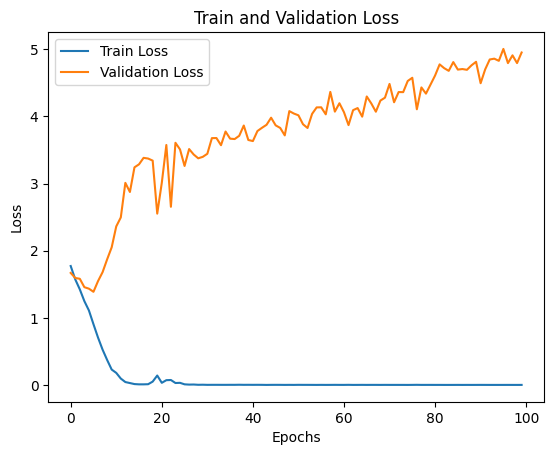

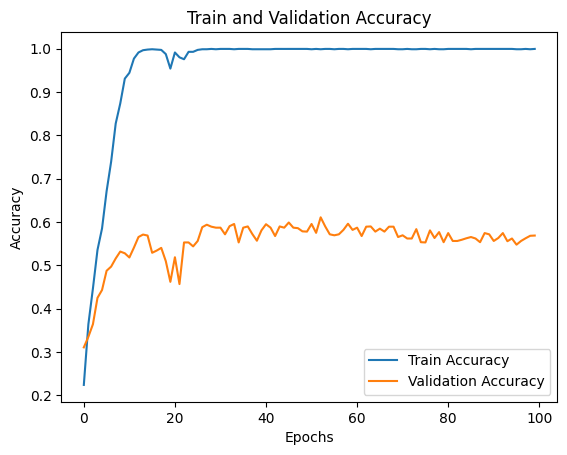

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy 0.5708333849906921


  0%|          | 0/10 [00:00<?, ?it/s]

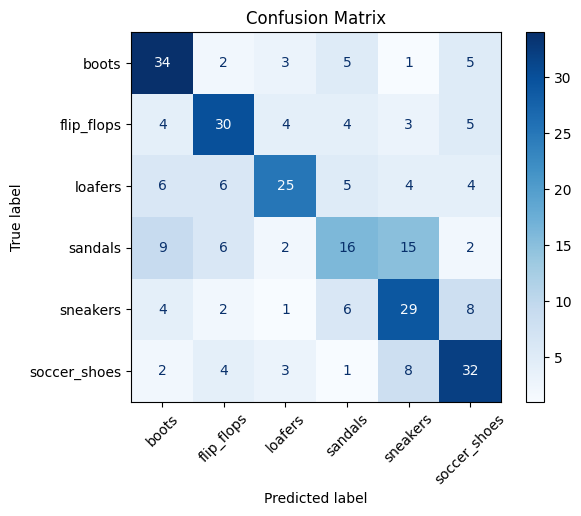

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure the model is in eval mode
model.eval()

# Lists to store true labels and predictions
true_labels = []
pred_labels = []

# Iterate over the test set
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(imgs)
    preds = torch.argmax(logits, dim=1)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
print(class_report)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

{'boots': {'precision': 0.576271186440678, 'recall': 0.68, 'f1-score': 0.6238532110091743, 'support': 50}, 'flip_flops': {'precision': 0.6, 'recall': 0.6, 'f1-score': 0.6, 'support': 50}, 'loafers': {'precision': 0.6578947368421053, 'recall': 0.5, 'f1-score': 0.5681818181818182, 'support': 50}, 'sandals': {'precision': 0.43243243243243246, 'recall': 0.32, 'f1-score': 0.36781609195402293, 'support': 50}, 'sneakers': {'precision': 0.48333333333333334, 'recall': 0.58, 'f1-score': 0.5272727272727273, 'support': 50}, 'soccer_shoes': {'precision': 0.5714285714285714, 'recall': 0.64, 'f1-score': 0.6037735849056605, 'support': 50}, 'accuracy': 0.5533333333333333, 'macro avg': {'precision': 0.5535600434128534, 'recall': 0.5533333333333333, 'f1-score': 0.5484829055539006, 'support': 300}, 'weighted avg': {'precision': 0.5535600434128534, 'recall': 0.5533333333333333, 'f1-score': 0.5484829055539006, 'support': 300}}


,precision,recall,f1-score,support
boots,0.576271,0.680000,0.623853,50.000000
flip_flops,0.600000,0.600000,0.600000,50.000000
loafers,0.657895,0.500000,0.568182,50.000000
sandals,0.432432,0.320000,0.367816,50.000000
sneakers,0.483333,0.580000,0.527273,50.000000
soccer_shoes,0.571429,0.640000,0.603774,50.000000
accuracy,0.553333,0.553333,0.553333,0.553333
macro avg,0.553560,0.553333,0.548483,300.000000
weighted avg,0.553560,0.553333,0.548483,300.000000
